In [1]:
nombre = "\nMadrigal Urencio Ricardo\n"

In [2]:
dir_hdfs = "hdfs://namenode:9000/tmp/amd/locatellimpio"

df = spark.read.csv(dir_hdfs, header = True, inferSchema = True)

print(nombre)
df.printSchema()

df.createOrReplaceTempView("locatel")
spark.sql("show tables").show()


Madrigal Urencio Ricardo

root
 |-- fecha_solicitud: date (nullable = true)
 |-- hora_solicitud: timestamp (nullable = true)
 |-- tema_solicitud: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- edad: double (nullable = true)
 |-- estatus: string (nullable = true)
 |-- alcaldia: string (nullable = true)
 |-- colonia_datos: string (nullable = true)
 |-- latitud: double (nullable = true)
 |-- longitud: double (nullable = true)
 |-- codigo_postal_solicitud: string (nullable = true)
 |-- d_codigo: integer (nullable = true)
 |-- D_mnpio: string (nullable = true)

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|         |  locatel|       true|
+---------+---------+-----------+



In [3]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
 
schema = StructType([
    StructField("d_codigo", StringType(), True),
    StructField("d_asenta", StringType(), True),
    StructField("d_tipo_asenta", StringType(), True),
    StructField("D_mnpio", StringType(), True),
    StructField("d_estado", StringType(), True),
    StructField("d_ciudad", StringType(), True),
    StructField("d_CP", StringType(), True),
    StructField("c_estado", StringType(), True),
    StructField("c_oficina", StringType(), True),
    StructField("c_CP", StringType(), True),
    StructField("c_tipo_asenta", StringType(), True),
    StructField("c_mnpio", StringType(), True),
    StructField("id_asenta_cpcons", StringType(), True),
    StructField("d_zona", StringType(), True),
    StructField("c_cve_ciudad", StringType(), True)
])

sepomex_df = spark.read\
            .option("header","true")\
            .option("delimiter", "|")\
            .option("skipRows", "1")\
            .option("encoding", "UTF-8")\
            .schema(schema)\
            .csv("hdfs://namenode:9000/tmp/amd/sepomex/")

sepomex_df.count()
sepomex_df.select(['d_codigo', 'D_mnpio', 'd_estado', 'd_ciudad']).distinct().createOrReplaceTempView("sepomex")
spark.sql("show tables").show()


+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|         |  locatel|       true|
|         |  sepomex|       true|
+---------+---------+-----------+



In [4]:
#Estadísticas específicas de un solo campo

sqlstr = """
select min(edad) as min_edad, max(edad) as max_edad, avg(edad) as avg_edad,
stddev(edad) as stddev_edad, count(edad) nr,
percentile_cont(0.5) within group (order by edad) as mediana_edad
from locatel
"""

spark.sql(sqlstr).show()

+--------+--------+-----------------+------------------+------+------------+
|min_edad|max_edad|         avg_edad|       stddev_edad|    nr|mediana_edad|
+--------+--------+-----------------+------------------+------+------------+
|     0.0| 16090.0|39.27146399881764|27.238747481977125|920192|        43.0|
+--------+--------+-----------------+------------------+------+------------+



In [5]:
spark.sql("select count(*) from locatel").show()

+--------+
|count(1)|
+--------+
| 2323089|
+--------+



In [6]:
sqlstr = """
select edad, count(*) nr 
from locatel 
group by edad 
order by edad desc
"""

spark.sql(sqlstr).show(20)

+-------+---+
|   edad| nr|
+-------+---+
|16090.0|  1|
|  100.0| 16|
|   99.0| 19|
|   98.0| 14|
|   97.0| 23|
|   96.0| 26|
|   95.0| 36|
|   94.0| 51|
|   93.0| 77|
|   92.0| 89|
|   91.0|109|
|   90.0|205|
|   89.0|212|
|   88.0|288|
|   87.0|377|
|   86.0|483|
|   85.0|698|
|   84.0|714|
|   83.0|847|
|   82.0|980|
+-------+---+
only showing top 20 rows



In [7]:
from pyspark.sql.functions import col, when, avg
edad_promedio = df.filter(col("edad") != 16090.0).agg(avg("edad")).first()[0]
edad_promedio

39.25402117603845

In [8]:
#Reemplazar el valor 16090 por la edad promedio
df = df.withColumn(
    "edad", when(col("edad") == 16090.0, edad_promedio).otherwise(col("edad"))
    )
df.createOrReplaceTempView("locatel")

In [9]:
#Estadísticas específicas de un solo campo

sqlstr = """
select min(edad) as min_edad, max(edad) as max_edad, avg(edad) as avg_edad,
stddev(edad) as stddev_edad, count(edad) nr,
percentile_cont(0.5) within group (order by edad) as mediana_edad
from locatel
"""

spark.sql(sqlstr).show()

+--------+--------+-----------------+-----------------+------+------------+
|min_edad|max_edad|         avg_edad|      stddev_edad|    nr|mediana_edad|
+--------+--------+-----------------+-----------------+------+------------+
|     0.0|   100.0|39.25402117603845|21.49369783924046|920192|        43.0|
+--------+--------+-----------------+-----------------+------+------------+



In [10]:
import matplotlib.pyplot as plt
df_edad = spark.sql("select edad from locatel where edad is not null")\
          .toPandas()

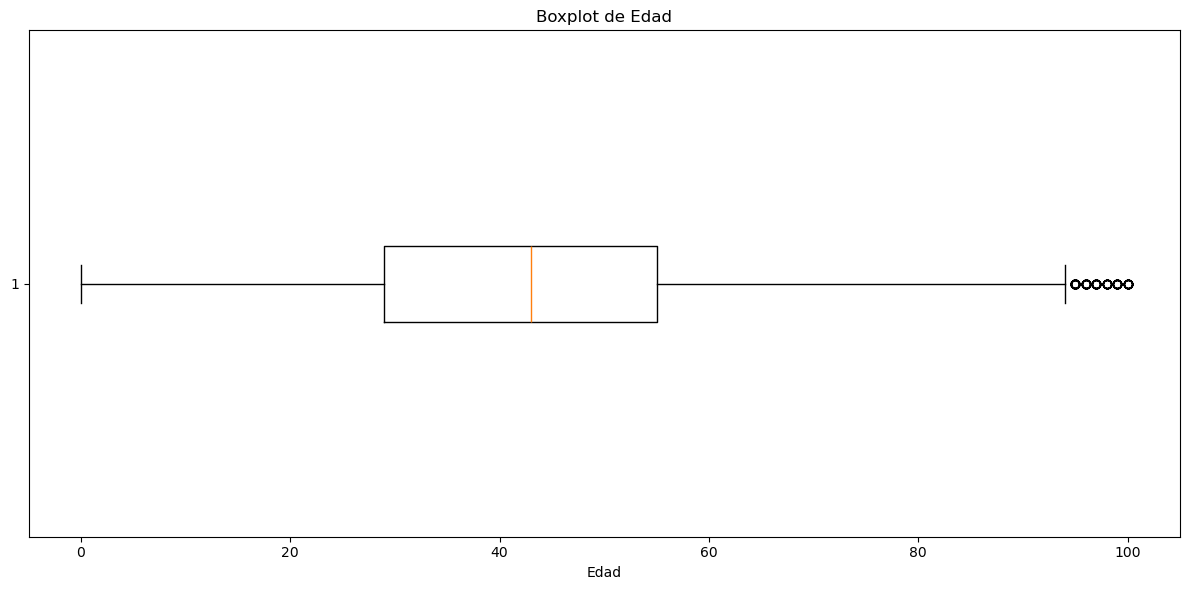

In [11]:
#Crear grafica de bocplot para edad
plt.figure(figsize=(12,6))
plt.boxplot(df_edad['edad'], vert = False)

plt.title("Boxplot de Edad")
plt.xlabel("Edad")

plt.tight_layout()
plt.show()

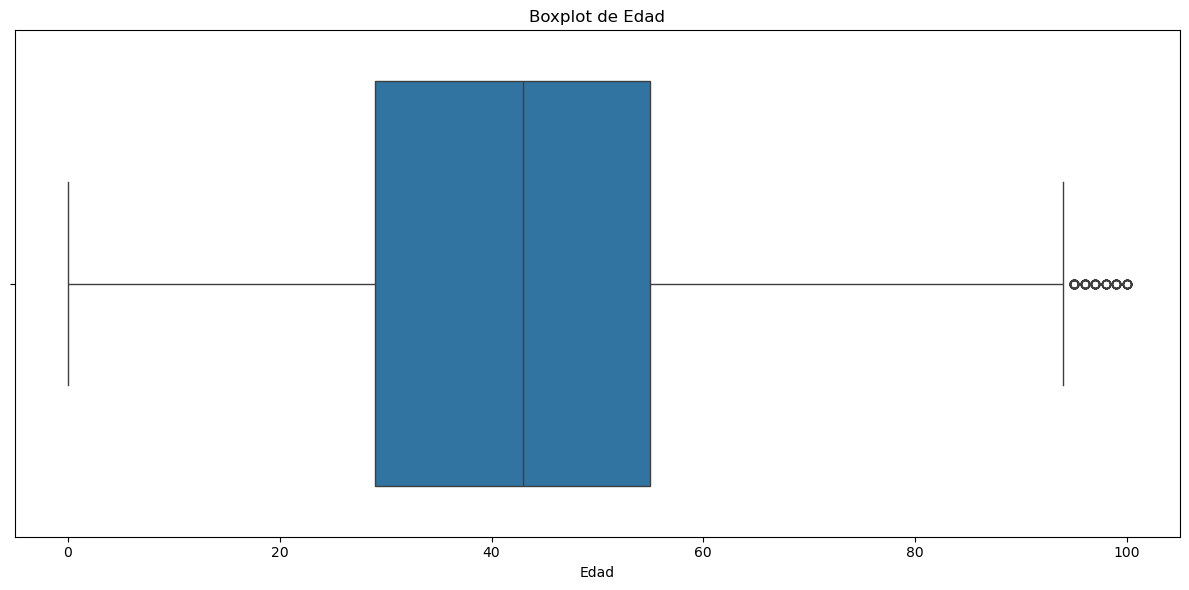

In [12]:
#Crear grafica de seaborn para edad
import seaborn as sns

plt.figure(figsize=(12,6))
#plt.boxplot(df_edad['edad'], vert = False)
sns.boxplot(df_edad['edad'], orient = 'h')

plt.title("Boxplot de Edad")
plt.xlabel("Edad")

plt.tight_layout()
plt.show()

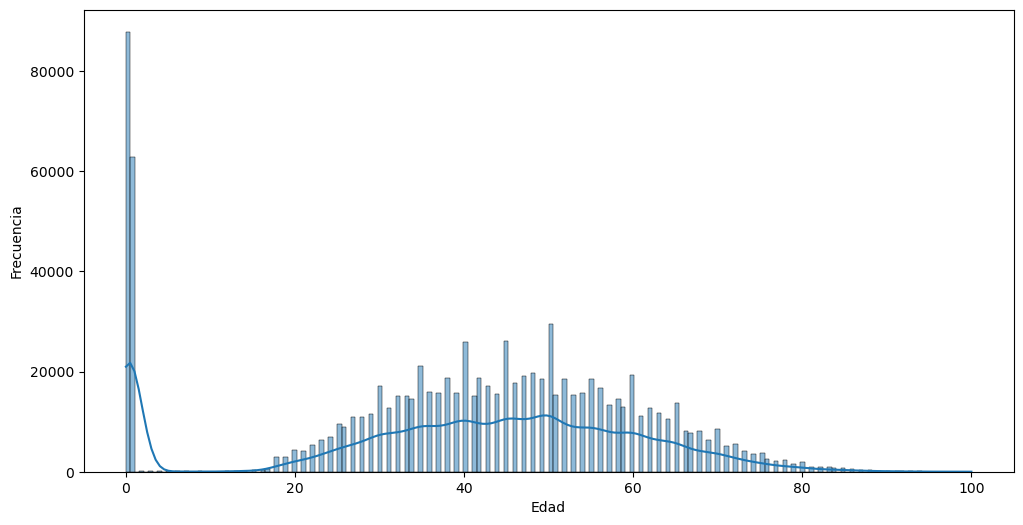

In [13]:
plt.figure(figsize=(12,6))
sns.histplot(data = df_edad, x = "edad", kde = True)
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()